In [1]:
import sys
sys.path.append('/g/data1a/e14/as3189/OFAM/scripts/')
import warnings
import numpy as np
import xarray as xr
from pathlib import Path
from itertools import groupby
from datetime import timedelta
import matplotlib.pyplot as plt
from main import paths, EUC_particles, ofam_fieldset, get_date
from main import plot3D, ParticleFile_transport, timer


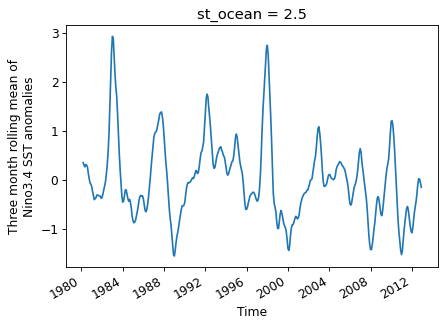

In [33]:
ds = xr.open_dataset(dpath/('ofam_sst_anom_nino34.nc'))
ds.oni.plot()

In [3]:
fpath, dpath, xpath, lpath, tpath = paths()
# tpath = Path('/g', 'data3', 'hh5', 'tmp', 'as3189', 'OFAM')
date_bnds = [get_date(1980, 1, 1), get_date(1985, 12, 'max')]
# date_bnds = [get_date(2070, 1, 1), get_date(2101, 12, 'max')]
temp = []
 
for y in range(date_bnds[0].year, date_bnds[1].year + 1):
    for m in range(date_bnds[0].month, date_bnds[1].month + 1):
        temp.append(xpath.joinpath('ocean_temp_{}_{:02d}.nc'.format(y, m)))

ds = xr.open_mfdataset(temp, combine='by_coords')

In [6]:
sst.resample(Time='MS').mean()

<xarray.DataArray 'temp' (Time: 60)>
dask.array<stack, shape=(60,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * Time      (Time) object 1981-01-01 00:00:00 ... 1985-12-01 00:00:00
    st_ocean  float64 2.5

In [19]:
# Select the SST averaged over the nino3.4 area.
sst = ds.sel(yt_ocean=slice(-5, 5), xt_ocean=slice(190, 240), st_ocean=2.5)
sst = sst.temp.mean(['yt_ocean', 'xt_ocean'])

# SST monthly climatology.
sst_clim = xr.open_dataset(xpath.joinpath('ocean_temp_1981-2012_climo.nc')).temp
sst_clim = sst_clim.sel(yt_ocean=slice(-5, 5), xt_ocean=slice(190, 240), st_ocean=2.5).mean(['yt_ocean', 'xt_ocean'])
# SST anomoly.
sst_anom = sst.resample(Time='MS').mean().groupby('Time.month') - sst_clim.groupby('Time.month').mean()

print(sst_anom)


<xarray.DataArray 'temp' (Time: 60)>
dask.array<getitem, shape=(60,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    st_ocean  float64 2.5
  * Time      (Time) object 1981-01-01 00:00:00 ... 1985-12-01 00:00:00
    month     (Time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12


In [25]:
# ONI index.
oni = sst_anom.rolling(Time=3).mean()
oni[0:5].load()

<xarray.DataArray (Time: 5)>
array([        nan,         nan, -0.322148  , -0.40343857, -0.37935004],
      dtype=float32)
Coordinates:
    st_ocean  float64 2.5
  * Time      (Time) object 1981-01-01 00:00:00 ... 1981-05-01 00:00:00
    month     (Time) int64 1 2 3 4 5

In [17]:
sst_clim.groupby('Time.month').mean()

<xarray.DataArray 'temp' (month: 12)>
array([27.463247, 27.508623, 27.788643, 28.184294, 28.382061, 28.36053 ,
       28.117952, 27.791235, 27.64592 , 27.623869, 27.633745, 27.556875],
      dtype=float32)
Coordinates:
    st_ocean  float64 2.5
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [22]:
sst.resample(Time='MS').mean()[0:5].load()

<xarray.DataArray 'temp' (Time: 5)>
array([27.238958, 27.105118, 27.449993, 27.716133, 28.050821],
      dtype=float32)
Coordinates:
  * Time      (Time) object 1981-01-01 00:00:00 ... 1981-05-01 00:00:00
    st_ocean  float64 2.5

In [23]:
27.238958 - 27.463247

-0.22428899999999885

In [26]:
# Create a categorical dataarray of events.
oni.load() # Need to load oni first.
nino34 = xr.full_like(oni, 'none', dtype='U4')
nino34[oni >= 0.5] = 'nino'
nino34[oni <= -0.5] = 'nina'

In [23]:
# Count the length time of each neutral, nino and nina. 
count_dups = [sum(1 for _ in grp) for _, grp in groupby(nino34)]

# Count the length time of each neutral event.
count_none = [sum(1 for _ in grp) for _, grp in groupby(nino34) if _ == 'none']

# Find the longest neutral event.
max_len = np.max(count_none)

# Find the index where the max event starts (in the count).
max_idx_dup = np.where(count_dups == max_len)[0][0]

# Sum the previous days to find index of event in nino34 array.
max_idx = sum(count_dups[0:max_idx_dup])

In [24]:
if not all(x == 'none' for x in nino34[max_idx:max_idx + max_len]):
    warnings.warn('Not all values are none.')
if nino34[max_idx -1] == 'none':
    warnings.warn('Previous time is not none.')
if nino34[max_idx + max_len] == 'none':
    warnings.warn('Next day is not none.')

print('Longest event: {} days'.format(max_len))
print('Index in count:', max_idx_dup)
print('Index in nino34:', max_idx)
strt = nino34[max_idx].Time.item()
end = nino34[max_idx + max_len].Time.item()
print('Start date:', strt)
print('End date:', end)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Previous time is not none.
  after removing the cwd from sys.path.


IndexError: index 11688 is out of bounds for axis 0 with size 11688

AttributeError: 'DataArrayRolling' object has no attribute 'Time'

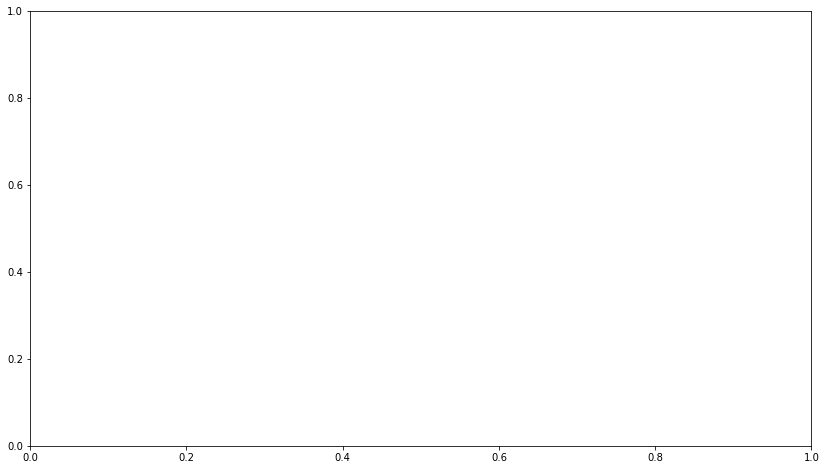

In [29]:
fig, ax = plt.subplots(figsize=(14, 8))
# ax.plot(oni.Time, sst_anom, 'green', label='SST_anom')
ax.plot(oni.Time, oni, 'k', label='ONI')

ax.fill_between(oni.Time.values, oni, 0.5, where=(oni>=0.5), facecolor=

'r', label='El Nino')
ax.fill_between(oni.Time.values, oni, -0.5, where=(oni<=-0.5), facecolor='b', label='La Nina')

ticks_to_use = oni.Time.values[::366*2]
labels = [ i.strftime("%-Y") for i in ticks_to_use ]
ax.set_xlim(oni.Time[0].item(), oni.Time[-1].item())
ax.set_xticks(ticks_to_use)
ax.set_xticklabels(labels, rotation=45)
ax.set_yticks(np.arange(-2, 3.5, 0.5))
ax.set_ylabel('SST [°C]')
ax.grid()
fig.legend()
plt.savefig(fpath.joinpath('ONI_{}-{}.png'.format(date_bnds[0].year, date_bnds[-1].year)))

In [26]:
oni

<xarray.DataArray (Time: 11688)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * Time      (Time) object 1981-01-01 12:00:00 ... 2012-12-31 12:00:00
    st_ocean  float64 2.5
    month     (Time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12

In [2]:
sst_anom

<xarray.DataArray 'temp' (Time: 11688)>
dask.array<getitem, shape=(11688,), dtype=float32, chunksize=(31,), chunktype=numpy.ndarray>
Coordinates:
    st_ocean  float64 2.5
  * Time      (Time) object 1981-01-01 12:00:00 ... 2012-12-31 12:00:00
    month     (Time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12

In [6]:
oni = sst_anom.rolling(month=5)

In [18]:
tmp = 
tmp

<xarray.DataArray 'temp' (month: 12, st_ocean: 51, yt_ocean: 300, xt_ocean: 1750)>
[321300000 values with dtype=float32]
Coordinates:
  * month     (month) datetime64[ns] 2012-01-31T12:00:00 ... 2012-12-31T12:00:00
  * xt_ocean  (xt_ocean) float64 120.1 120.2 120.2 120.3 ... 294.8 294.9 295.0
  * yt_ocean  (yt_ocean) float64 -14.95 -14.85 -14.75 ... 14.75 14.85 14.95
  * st_ocean  (st_ocean) float64 2.5 7.5 12.5 ... 2.895e+03 3.603e+03 4.509e+03
Attributes:
    standard_name:  sea_water_potential_temperature
    long_name:      Potential temperature
    units:          degrees C
    packing:        4
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

In [4]:
xr.open_dataset(xpath.joinpath('ocean_temp_1981-2012_climo.nc'))

<xarray.Dataset>
Dimensions:     (Time: 12, st_ocean: 51, xt_ocean: 1750, yt_ocean: 300)
Coordinates:
  * Time        (Time) datetime64[ns] 2012-01-31T12:00:00 ... 2012-12-31T12:00:00
  * xt_ocean    (xt_ocean) float64 120.1 120.2 120.2 120.3 ... 294.8 294.9 295.0
  * yt_ocean    (yt_ocean) float64 -14.95 -14.85 -14.75 ... 14.75 14.85 14.95
  * st_ocean    (st_ocean) float64 2.5 7.5 12.5 ... 3.603e+03 4.509e+03
Data variables:
    average_DT  (Time) timedelta64[ns] ...
    temp        (Time, st_ocean, yt_ocean, xt_ocean) float32 ...
Attributes:
    CDI:            Climate Data Interface version 1.9.6 (http://mpimet.mpg.d...
    Conventions:    CF-1.6
    history:        Fri Sep 27 23:49:35 2019: cdo -O -ymonmean,-selyear,1981/...
    filename:       TMP/ocean_ofam_1981_01.nc.0000
    NumFilesInSet:  720
    title:          jra_55_1979
    grid_type:      regular
    NCO:            netCDF Operators version 4.7.7 (Homepage = http://nco.sf....
    CDO:            Climate Data Operators v